# Convolutional Neural Networks

Realizaremos un ejercicio descrito en el blog www.aprendemachinelearning.com para hacer reconocimiento de imágenes.

# Importar Librerías

In [81]:
from skimage.transform import resize
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [82]:
#import keras
#from keras.utils import to_categorical
#from keras.models import Sequential,Input,Model
#from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
#from keras.layers.normalization import BatchNormalization
#from keras.layers.advanced_activations import LeakyReLU

import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU


# Cargar set de Imágenes

In [ ]:
# Ejecutar solo en google colab
! git clone -b EX-CNN https://github.com/thonyguev/machine-learning.git

In [83]:
# Ejecutar solo en entorno local
dirImages = "sportimages"
imageTest = "test/golf_0113.jpg"

In [ ]:
# Ejecutar solo en google colab
dirImages = "machine-learning/sportimages"
imageTest = "machine-learning/test/golf_0113.jpg"

In [84]:
dirname = os.path.join(os.getcwd(), dirImages)
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  /home/sportimages/
/home/sportimages/sportimages/f1 1
/home/sportimages/sportimages/futbol 5053
/home/sportimages/sportimages/boxeo 7617
/home/sportimages/sportimages/ciclismo 7125
/home/sportimages/sportimages/natacion 7533
/home/sportimages/sportimages/americano 5172
/home/sportimages/sportimages/basket 9348
/home/sportimages/sportimages/golf 8823
/home/sportimages/sportimages/beisball 9768
/home/sportimages/sportimages/tenis 7752
Directorios leidos: 10
Imagenes en cada directorio [5054, 7617, 7125, 7533, 5172, 9348, 8823, 9768, 7752, 8936]
suma Total de imagenes en subdirs: 77128


# Creamos las etiquetas

In [85]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))

Cantidad etiquetas creadas:  77128


In [86]:
deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1

0 f1
1 futbol
2 boxeo
3 ciclismo
4 natacion
5 americano
6 basket
7 golf
8 beisball
9 tenis


In [87]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy

# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


# Creamos Sets de Entrenamiento y Test

In [88]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (61702, 21, 28, 3) (61702,)
Testing data shape :  (15426, 21, 28, 3) (15426,)


Text(0.5, 1.0, 'Ground Truth : 2')

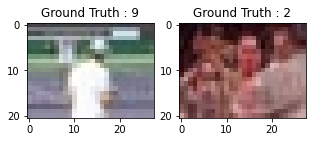

In [89]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

# Preprocesamos las imagenes

In [90]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

## Hacemos el One-hot Encoding para la red

In [91]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 9
After conversion to one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


# Creamos el Set de Entrenamiento y Validación

In [92]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [93]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(49361, 21, 28, 3) (12341, 21, 28, 3) (49361, 10) (12341, 10)


# Creamos el modelo de CNN

In [94]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 6 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 64 # cantidad de imágenes que se toman a la vez en memoria

In [95]:
sport_model = Sequential()
sport_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(21,28,3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))

sport_model.add(Flatten())
sport_model.add(Dense(32, activation='linear'))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(Dropout(0.5))
sport_model.add(Dense(nClasses, activation='softmax'))

In [96]:
sport_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 21, 28, 32)        896       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 21, 28, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 11, 14, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 4928)              0         
                                                                 
 dense_2 (Dense)             (None, 32)                157728    
                                                      

In [97]:
sport_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adagrad(learning_rate=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

# Entrenamos el modelo: Aprende a clasificar imágenes

In [98]:
# este paso puede tomar varios minutos, dependiendo de tu ordenador, cpu y memoria ram libre
# como ejemplo, en mi Macbook pro tarda 4 minutos
sport_train = sport_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/6


2022-07-09 06:37:45.192190: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 348291216 exceeds 10% of free system memory.


772/772 [==============================] - 11s 13ms/step - loss: 2.1289 - accuracy: 0.2357 - val_loss: 1.7974 - val_accuracy: 0.5923
Epoch 2/6
772/772 [==============================] - 10s 12ms/step - loss: 1.7667 - accuracy: 0.4053 - val_loss: 1.4344 - val_accuracy: 0.6650
Epoch 3/6
772/772 [==============================] - 10s 13ms/step - loss: 1.5403 - accuracy: 0.4812 - val_loss: 1.2319 - val_accuracy: 0.6939
Epoch 4/6
772/772 [==============================] - 10s 12ms/step - loss: 1.4009 - accuracy: 0.5253 - val_loss: 1.1066 - val_accuracy: 0.7185
Epoch 5/6
772/772 [==============================] - 10s 12ms/step - loss: 1.3015 - accuracy: 0.5616 - val_loss: 1.0196 - val_accuracy: 0.7250
Epoch 6/6
772/772 [==============================] - 10s 12ms/step - loss: 1.2342 - accuracy: 0.5838 - val_loss: 0.9585 - val_accuracy: 0.7399


In [99]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
sport_model.save("sports_mnist.h5py")

INFO:tensorflow:Assets written to: sports_mnist.h5py/assets


INFO:tensorflow:Assets written to: sports_mnist.h5py/assets


# Evaluamos la red

In [100]:
test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)

483/483 [==============================] - 2s 3ms/step - loss: 0.9593 - accuracy: 0.7374


In [101]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.9593003392219543
Test accuracy: 0.7373914122581482


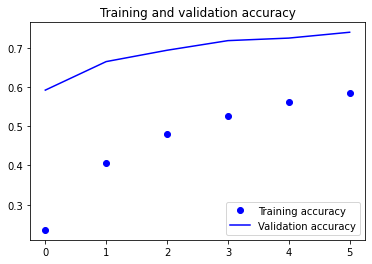

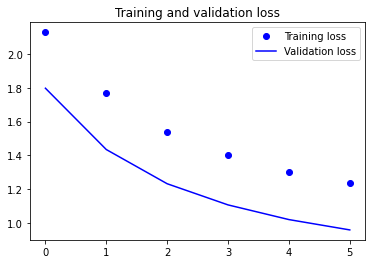

In [102]:
accuracy = sport_train.history['accuracy']
val_accuracy = sport_train.history['val_accuracy']
loss = sport_train.history['loss']
val_loss = sport_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [103]:
predicted_classes2 = sport_model.predict(test_X)

483/483 [==============================] - 1s 3ms/step


In [104]:
predicted_classes=[]
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes=np.array(predicted_classes)

In [105]:
predicted_classes.shape, test_Y.shape

((15426,), (15426,))

# Aprendamos de los errores: Qué mejorar

Found 11375 correct labels


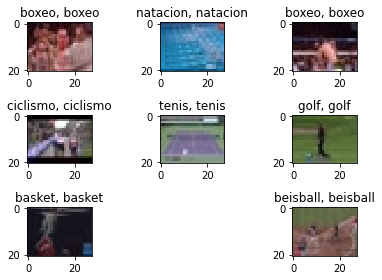

In [106]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[correct]],
                                                    deportes[test_Y[correct]]))

    plt.tight_layout()

Found 4051 incorrect labels


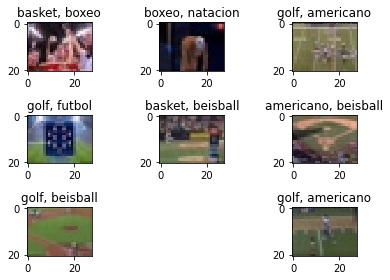

In [107]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[incorrect]],
                                                    deportes[test_Y[incorrect]]))
    plt.tight_layout()

In [108]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.71      0.22      0.33      1043
     Class 1       0.85      0.68      0.76      1528
     Class 2       0.74      0.90      0.81      1459
     Class 3       0.93      0.99      0.96      1455
     Class 4       0.86      0.87      0.86       986
     Class 5       0.52      0.33      0.41      1845
     Class 6       0.75      0.74      0.74      1761
     Class 7       0.51      0.86      0.64      1992
     Class 8       0.75      0.69      0.72      1529
     Class 9       0.96      1.00      0.98      1828

    accuracy                           0.74     15426
   macro avg       0.76      0.73      0.72     15426
weighted avg       0.75      0.74      0.72     15426



# Prediccion de una nueva imagen

In [109]:
images=[]
# AQUI ESPECIFICAMOS UNAS IMAGENES
filenames = [imageTest]

for filepath in filenames:
    image = plt.imread(filepath,0)
    image_resized = resize(image, (21, 28),anti_aliasing=True,clip=False,preserve_range=True)
    images.append(image_resized)

X = np.array(images, dtype=np.uint8) #convierto de lista a numpy
test_X = X.astype('float32')
test_X = test_X / 255.

predicted_classes = sport_model.predict(test_X)

for i, img_tagged in enumerate(predicted_classes):
    print(filenames[i], deportes[img_tagged.tolist().index(max(img_tagged))])

1/1 [==============================] - 0s 20ms/step
test/golf_0113.jpg golf
